In [249]:
# !pip install split-folders

In [250]:
# import splitfolders
# splitfolders.ratio("D:\\Stroke Data", output="D:\\Stroke Data_Splitted\\",seed=1337, ratio=(.7, .3), group_prefix=None, move=False)

In [317]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt            
import warnings
warnings.filterwarnings('ignore') 
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import mediapipe as mp
import time
import os
from glob import glob

from collections import Counter
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder

mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils # For drawing keypoints
points = mpPose.PoseLandmark # Landmarks
data = []
a=0

In [319]:
Straight_Drive_df=pd.read_csv("Straight_Drive.csv")
Sweep_df=pd.read_csv("Sweep.csv")
Pull_df=pd.read_csv("Pull.csv")
onDrive_df=pd.read_csv("onDrive.csv")
Flick_df=pd.read_csv("Flick.csv")
Cut_df=pd.read_csv("Cut.csv")
Cover_Drive_df=pd.read_csv("Cover_Drive.csv")
back_foot_punch_df=pd.read_csv("back_foot_punch.csv")

In [321]:
dataframes = [ Cover_Drive_df]

In [323]:
Posdataset=pd.concat(dataframes, ignore_index=True)
Posdataset.head(5)

,Unnamed: 0,F0_x,F0_y,F0_z,F0_vis,F1_x,F1_y,F1_z,F1_vis,F2_x,...,F30_vis,F31_x,F31_y,F31_z,F31_vis,F32_x,F32_y,F32_z,F32_vis,Label
0,850,0.605604,0.319193,-0.206423,0.998100,0.608060,0.310672,-0.205325,0.997993,0.609513,...,0.704735,0.636576,0.643802,-0.210230,0.918661,0.629231,0.632027,0.011629,0.861975,Cover Drive
1,851,0.605210,0.320216,-0.195480,0.998275,0.607313,0.310882,-0.193891,0.998183,0.608708,...,0.693936,0.637445,0.648802,-0.216752,0.922947,0.629856,0.631912,-0.047416,0.844693,Cover Drive
2,852,0.605156,0.321100,-0.198475,0.998430,0.607107,0.311066,-0.197096,0.998352,0.608519,...,0.685689,0.637536,0.646330,-0.215665,0.927065,0.630199,0.631907,-0.039618,0.830709,Cover Drive
3,853,0.602378,0.320967,-0.149304,0.998564,0.604508,0.311048,-0.147209,0.998500,0.605890,...,0.679551,0.637206,0.644141,-0.173419,0.930712,0.631187,0.631652,-0.020749,0.814591,Cover Drive
4,854,0.600436,0.320933,-0.092031,0.998703,0.602337,0.311165,-0.096430,0.998647,0.603642,...,0.685475,0.637198,0.642320,-0.159816,0.936338,0.632738,0.629347,0.058007,0.807283,Cover Drive


In [325]:
Posdataset.shape

(843, 134)

In [327]:
Posdataset = Posdataset.drop(columns=['Unnamed: 0', 'Label'], axis=1)

In [329]:
Posdataset

,F0_x,F0_y,F0_z,F0_vis,F1_x,F1_y,F1_z,F1_vis,F2_x,F2_y,...,F30_z,F30_vis,F31_x,F31_y,F31_z,F31_vis,F32_x,F32_y,F32_z,F32_vis
0,0.605604,0.319193,-0.206423,0.998100,0.608060,0.310672,-0.205325,0.997993,0.609513,0.310109,...,0.052371,0.704735,0.636576,0.643802,-0.210230,0.918661,0.629231,0.632027,0.011629,0.861975
1,0.605210,0.320216,-0.195480,0.998275,0.607313,0.310882,-0.193891,0.998183,0.608708,0.310283,...,-0.000988,0.693936,0.637445,0.648802,-0.216752,0.922947,0.629856,0.631912,-0.047416,0.844693
2,0.605156,0.321100,-0.198475,0.998430,0.607107,0.311066,-0.197096,0.998352,0.608519,0.310419,...,0.006449,0.685689,0.637536,0.646330,-0.215665,0.927065,0.630199,0.631907,-0.039618,0.830709
3,0.602378,0.320967,-0.149304,0.998564,0.604508,0.311048,-0.147209,0.998500,0.605890,0.310358,...,0.022291,0.679551,0.637206,0.644141,-0.173419,0.930712,0.631187,0.631652,-0.020749,0.814591
4,0.600436,0.320933,-0.092031,0.998703,0.602337,0.311165,-0.096430,0.998647,0.603642,0.310417,...,0.083066,0.685475,0.637198,0.642320,-0.159816,0.936338,0.632738,0.629347,0.058007,0.807283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,0.370345,0.428195,-0.144750,0.999727,0.370304,0.414213,-0.138064,0.999512,0.371826,0.411462,...,0.334093,0.937081,0.404485,0.795220,-0.134287,0.993603,0.478267,0.735896,0.305060,0.935819
839,0.370240,0.427272,-0.130157,0.999737,0.370136,0.412917,-0.124017,0.999530,0.371542,0.409943,...,0.331429,0.935869,0.406225,0.794563,-0.129014,0.993532,0.480297,0.735304,0.305004,0.934787
840,0.371180,0.426987,-0.130847,0.999753,0.370511,0.412608,-0.125698,0.999558,0.371856,0.409479,...,0.348485,0.936068,0.407828,0.791429,-0.119812,0.993582,0.481620,0.733718,0.320851,0.935420
841,0.371631,0.425884,-0.138900,0.999768,0.370875,0.412018,-0.132815,0.999588,0.372210,0.408954,...,0.341062,0.934625,0.408163,0.788730,-0.146061,0.993747,0.482890,0.731817,0.319548,0.934437


In [331]:
frames=Posdataset.iloc[0]
frames

F0_x       0.605604
F0_y       0.319193
F0_z      -0.206423
F0_vis     0.998100
F1_x       0.608060
             ...   
F31_vis    0.918661
F32_x      0.629231
F32_y      0.632027
F32_z      0.011629
F32_vis    0.861975
Name: 0, Length: 132, dtype: float64

In [333]:
import pandas as pd
import cv2
import numpy as np

# Assuming Posdataset is your DataFrame containing the pose data
# Define the size of the video frame
frame_width = 640  # Adjust as needed
frame_height = 480  # Adjust as needed
fps = 30  # Frames per second

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for .avi
video = cv2.VideoWriter('pose_animation.avi', fourcc, fps, (frame_width, frame_height))

# Loop through each frame
for f in range(len(Posdataset)):
    frames = Posdataset.iloc[f]
    frames = pd.Series(frames)

    # Extract the x, y coordinates for each joint
    keypoints = []
    for i in range(33):  # 0 to 32 for 33 keypoints
        x = frames[f'F{i}_x']
        y = frames[f'F{i}_y']
        visibility = frames[f'F{i}_vis']
        
        # Only include visible keypoints
        if visibility > 0.4:
            keypoints.append((x, y))

    # Create a black image for the current frame
    frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)

    # Convert keypoints to a NumPy array for easier manipulation
    keypoints = pd.DataFrame(keypoints, columns=['x', 'y'])

    # Draw the keypoints on the frame
    for _, row in keypoints.iterrows():
        cv2.circle(frame, (int(row['x'] * frame_width), int(row['y'] * frame_height)), 5, (255, 0, 0), -1)

    # Define connections between keypoints to draw the skeleton
    connections = [
        (0, 1), (1, 2), (2, 3),  # Left eye connections
        (0, 4), (4, 5), (5, 6),  # Right eye connections
        (0, 7), (0, 8),  # Nose to ears
        (9, 10),  # Mouth connection
        (11, 12),  # Shoulders
        (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
        (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
        (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
        (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
        (23, 24),  # Hips
        (11, 23), (12, 24),  # Shoulders to hips
        (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
        (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
    ]

    # Draw connections on the frame
    for start, end in connections:
        if start < len(keypoints) and end < len(keypoints):
            cv2.line(frame, 
                     (int(keypoints['x'].iloc[start] * frame_width), int(keypoints['y'].iloc[start] * frame_height)),
                     (int(keypoints['x'].iloc[end] * frame_width), int(keypoints['y'].iloc[end] * frame_height)),
                     (0, 0, 255), 2)  # Red color for lines

    # Write the frame to the video file
    video.write(frame)

# Release the video writer
video.release()

print("Video saved as pose_animation.avi")


Video saved as pose_animation.avi


In [334]:
len(Posdataset)

843

In [335]:
PredictedFrame = pd.DataFrame([frames], columns=data)
xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
predicted_xyz = PredictedFrame[xyz_columns]

In [339]:
PredictedFrame

""
842


In [313]:
dataframes = [back_foot_punch_df, Cover_Drive_df, Cut_df, Flick_df, onDrive_df, Pull_df, Straight_Drive_df, Sweep_df]

# Concatenating the DataFrames
dataset = pd.concat(dataframes, ignore_index=True)


In [4]:
dataset.head(2)

,Unnamed: 0,F0_x,F0_y,F0_z,F0_vis,F1_x,F1_y,F1_z,F1_vis,F2_x,...,F30_vis,F31_x,F31_y,F31_z,F31_vis,F32_x,F32_y,F32_z,F32_vis,Label
0,0,0.474017,0.251514,-0.142690,0.999977,0.476500,0.242105,-0.141993,0.999983,0.478387,...,0.313809,0.488748,0.534360,-0.061681,0.592151,0.480158,0.523336,0.018530,0.291662,back foot punch
1,1,0.472944,0.249560,-0.124287,0.999952,0.475619,0.239768,-0.126271,0.999963,0.477422,...,0.309853,0.488756,0.576981,-0.084525,0.611492,0.479105,0.561661,0.021766,0.298080,back foot punch


(6362, 133)

In [13]:
newdataset=dataset
newdataset.head(2)

,F0_x,F0_y,F0_z,F0_vis,F1_x,F1_y,F1_z,F1_vis,F2_x,F2_y,...,F30_vis,F31_x,F31_y,F31_z,F31_vis,F32_x,F32_y,F32_z,F32_vis,Label
0,0.474017,0.251514,-0.142690,0.999977,0.476500,0.242105,-0.141993,0.999983,0.478387,0.241543,...,0.313809,0.488748,0.534360,-0.061681,0.592151,0.480158,0.523336,0.018530,0.291662,back foot punch
1,0.472944,0.249560,-0.124287,0.999952,0.475619,0.239768,-0.126271,0.999963,0.477422,0.239116,...,0.309853,0.488756,0.576981,-0.084525,0.611492,0.479105,0.561661,0.021766,0.298080,back foot punch


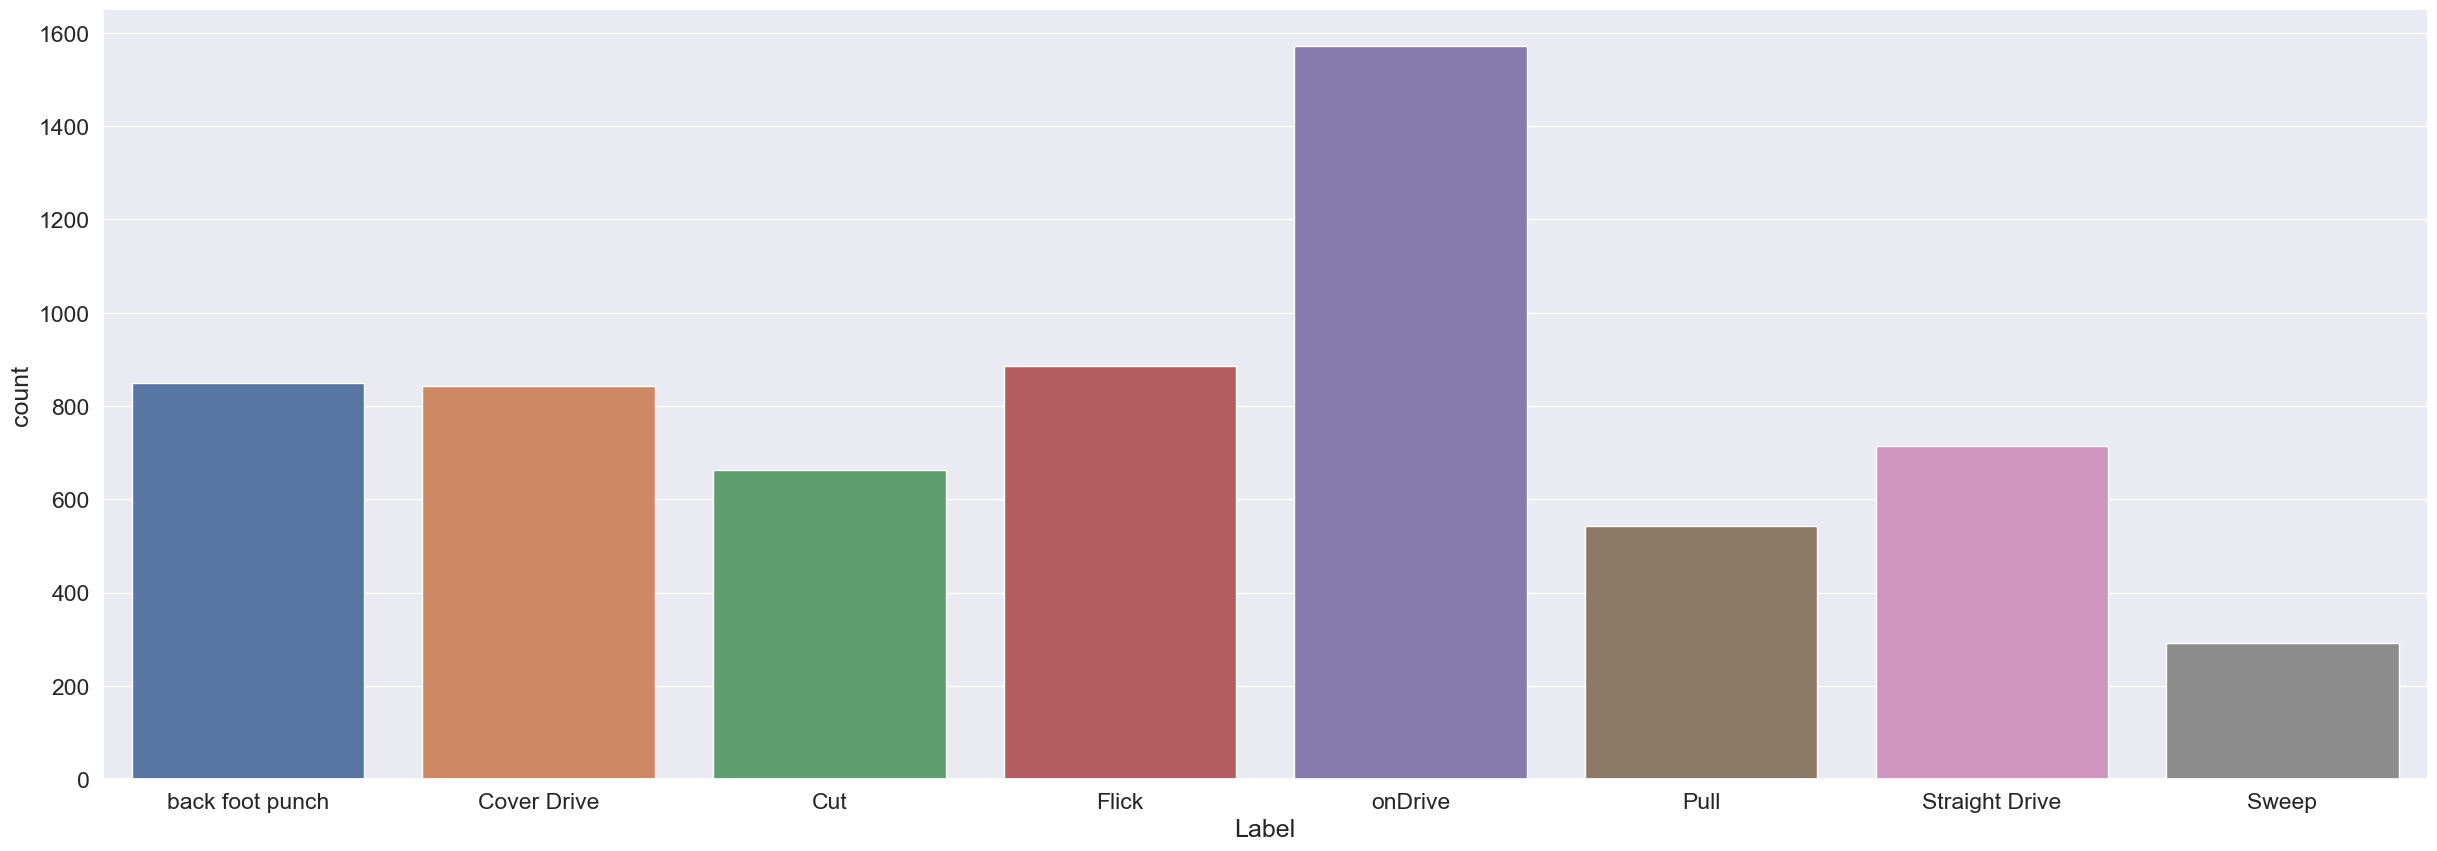

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

class_label = "Label"
# Setting the figure size and font scale
sns.set(font_scale=1.5, rc={'figure.figsize':(30,10)})
# Count plot of the label column
sns.countplot(x=class_label, data=newdataset, label="Count")

# Display the plot
plt.show()


In [17]:
Features=newdataset.drop(['Label'], axis=1)

In [20]:
import sklearn
newdataset = sklearn.utils.shuffle(newdataset)

In [22]:
# newdataset.to_csv("Splitted_features.csv")

In [24]:
# newdataset=pd.read_csv("Splitted_features.csv", index_col=[0])

In [27]:
newdataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6362 entries, 1283 to 3308
Columns: 133 entries, F0_x to Label
dtypes: float64(132), object(1)
memory usage: 6.5+ MB


In [29]:
newdataset.describe()

,F0_x,F0_y,F0_z,F0_vis,F1_x,F1_y,F1_z,F1_vis,F2_x,F2_y,...,F30_z,F30_vis,F31_x,F31_y,F31_z,F31_vis,F32_x,F32_y,F32_z,F32_vis
count,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,...,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000
mean,0.463918,0.360117,-0.145781,0.998581,0.465100,0.349436,-0.144183,0.998331,0.466417,0.348391,...,0.083020,0.767736,0.487282,0.727452,-0.131909,0.946581,0.463945,0.710607,0.040298,0.839184
std,0.073657,0.098189,0.127731,0.002875,0.074034,0.099529,0.124455,0.003517,0.074191,0.099563,...,0.128544,0.132191,0.072526,0.103813,0.132811,0.075670,0.083071,0.104667,0.146522,0.105462
min,0.065575,0.049638,-0.691717,0.949400,0.064307,0.030998,-0.691346,0.947469,0.063439,0.031400,...,-0.289892,0.309853,0.047152,0.312518,-0.609694,0.403472,0.086361,0.271760,-0.424819,0.291662
25%,0.428743,0.283888,-0.209350,0.998576,0.430290,0.271148,-0.202275,0.998326,0.431745,0.269962,...,-0.011598,0.690574,0.451291,0.633122,-0.213954,0.945730,0.440152,0.619604,-0.059655,0.778040
50%,0.463072,0.359314,-0.130966,0.999478,0.465252,0.349772,-0.127343,0.999391,0.466890,0.348755,...,0.077135,0.786194,0.492728,0.746779,-0.139234,0.971657,0.469732,0.723969,0.035606,0.855493
75%,0.497081,0.437134,-0.058277,0.999801,0.498272,0.427536,-0.058855,0.999756,0.499871,0.426431,...,0.170412,0.871157,0.520869,0.807969,-0.071408,0.987173,0.498202,0.784522,0.145021,0.924535
max,0.692433,0.890094,0.292866,0.999996,0.690683,0.894528,0.293331,0.999997,0.690171,0.894847,...,0.623692,0.981729,0.753133,1.029287,0.620302,0.998754,0.736652,1.016885,0.616928,0.991898


In [30]:
newdataset.nunique()

F0_x       6360
F0_y       6360
F0_z       6362
F0_vis     5699
F1_x       6357
           ... 
F32_x      6357
F32_y      6356
F32_z      6362
F32_vis    6359
Label         8
Length: 133, dtype: int64

In [33]:
newdataset.isnull().sum()

F0_x       0
F0_y       0
F0_z       0
F0_vis     0
F1_x       0
          ..
F32_x      0
F32_y      0
F32_z      0
F32_vis    0
Label      0
Length: 133, dtype: int64

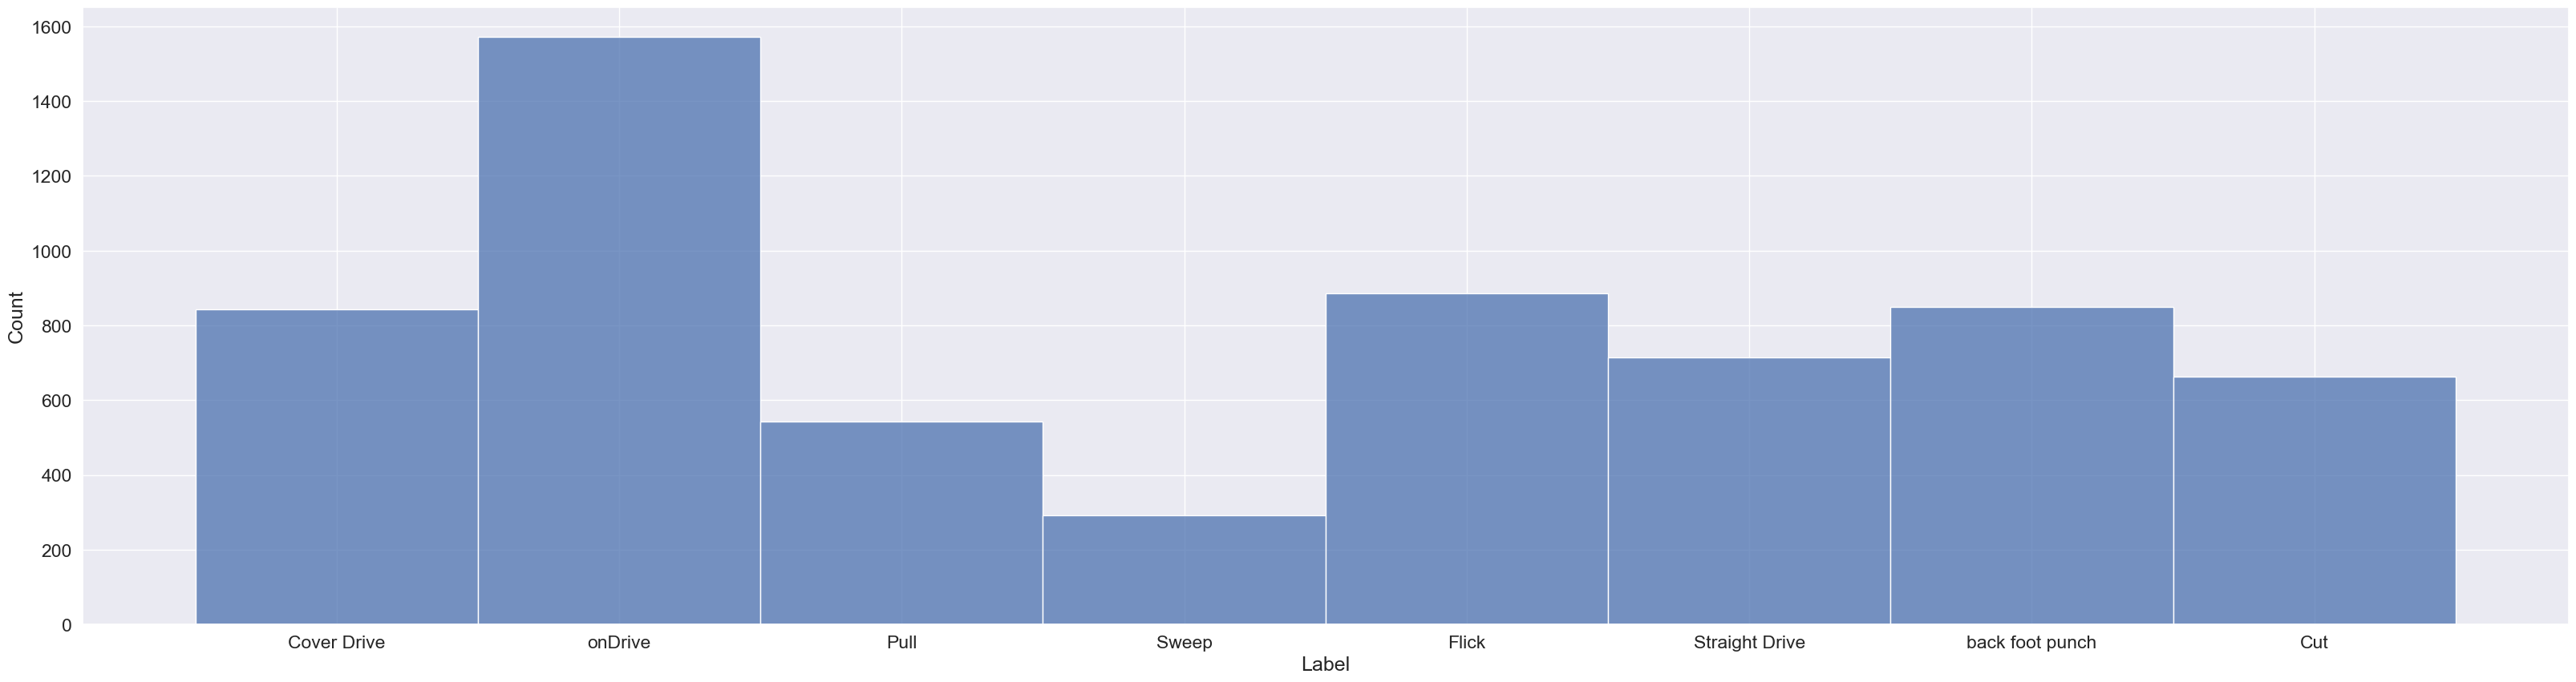

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5, rc={'figure.figsize':(40,10)})
sns.histplot(x='Label', data=newdataset, )
plt.show()

([<matplotlib.patches.Wedge at 0x269ece2b390>,
 [Text(0.784890575227832, 0.770679430709373, 'onDrive'),
  Text(-0.44777417577500156, 1.0047379198124347, 'Flick'),
  Text(-1.0527033154083043, 0.31908577174227676, 'back foot punch'),
  Text(-0.9425139494174597, -0.5671573460279805, 'Cover Drive'),
  Text(-0.28251423073854076, -1.0631019280530962, 'Straight Drive'),
  Text(0.44876621134058015, -1.004295219324986, 'Cut'),
  Text(0.9342956390887217, -0.5805959513980418, 'Pull'),
  Text(1.0885846724265633, -0.15806141514598587, 'Sweep')],
 [Text(0.4281221319424538, 0.4203705985687488, '24.7%\n(1572)'),
  Text(-0.24424045951363718, 0.548038865352237, '13.9%\n(886)'),
  Text(-0.5742018084045295, 0.1740467845866964, '13.4%\n(850)'),
  Text(-0.5140985178640689, -0.3093585523788984, '13.3%\n(843)'),
  Text(-0.1540986713119313, -0.5798737789380525, '11.2%\n(715)'),
  Text(0.2447815698221346, -0.5477973923590833, '10.4%\n(662)'),
  Text(0.5096158031393027, -0.31668870076256816, '8.5%\n(542)'),
  Te

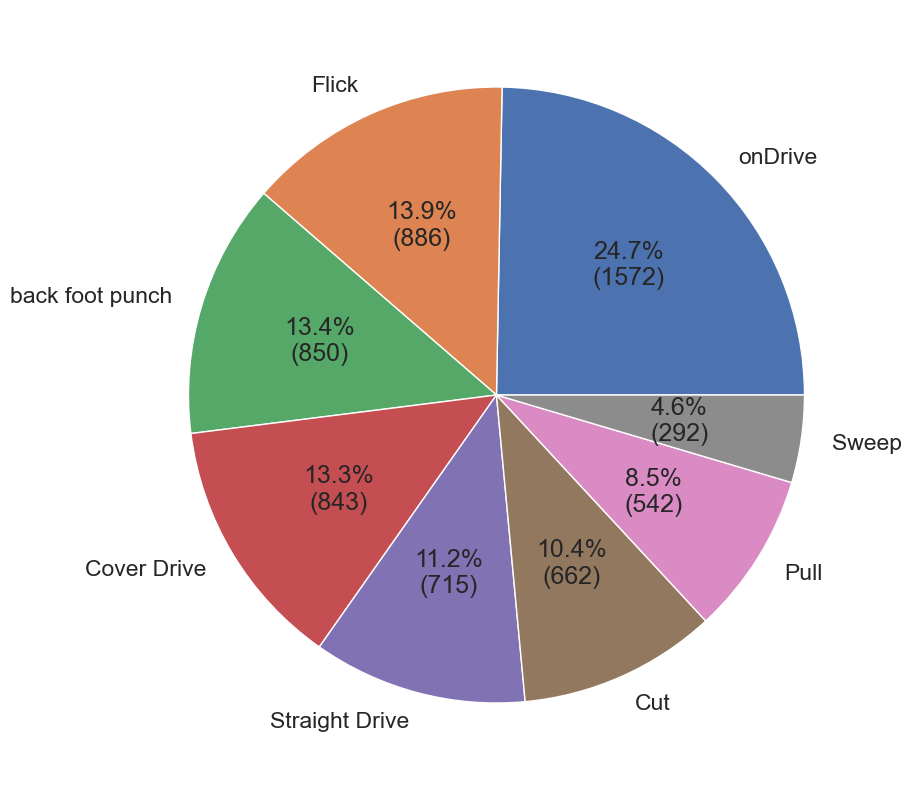

In [38]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

s = newdataset["Label"].value_counts()
plt.pie(s,labels = s.index, autopct=autopct_format(s))

In [41]:
labels=newdataset["Label"]
Features=newdataset.drop(['Label'], axis=1)


In [43]:
Features

,F0_x,F0_y,F0_z,F0_vis,F1_x,F1_y,F1_z,F1_vis,F2_x,F2_y,...,F30_z,F30_vis,F31_x,F31_y,F31_z,F31_vis,F32_x,F32_y,F32_z,F32_vis
1283,0.322509,0.473727,-0.126162,0.999908,0.322743,0.460354,-0.117895,0.999934,0.324443,0.457162,...,0.301709,0.961572,0.350925,0.826735,-0.243075,0.996122,0.468028,0.788783,0.265662,0.961373
4037,0.520313,0.333693,-0.071381,0.996731,0.521076,0.325487,-0.068136,0.997132,0.522443,0.324280,...,0.008641,0.711263,0.542931,0.519926,-0.002867,0.862419,0.530021,0.533653,-0.013106,0.784023
4899,0.277692,0.203378,-0.011194,0.997717,0.275950,0.185058,-0.001898,0.997241,0.275385,0.184368,...,-0.057956,0.967250,0.362681,0.809333,-0.016072,0.981548,0.254939,0.864759,-0.127218,0.990296
1642,0.422905,0.431284,-0.065125,0.999918,0.425658,0.420430,-0.070786,0.999894,0.427089,0.419841,...,0.139877,0.865595,0.430143,0.756238,-0.014035,0.989294,0.472725,0.743221,0.142531,0.878899
6228,0.415983,0.298200,-0.263453,0.999015,0.419939,0.286659,-0.255169,0.998744,0.422192,0.286422,...,-0.127092,0.693761,0.437344,0.728155,-0.320710,0.876502,0.414605,0.684547,-0.195969,0.767631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,0.475101,0.222156,-0.273602,0.999454,0.477470,0.206481,-0.268532,0.999369,0.479713,0.205203,...,-0.116684,0.685214,0.505292,0.635481,-0.280269,0.924360,0.491253,0.635422,-0.200121,0.796009
1826,0.460402,0.500877,-0.108105,0.999894,0.463174,0.489387,-0.107432,0.999844,0.465311,0.488659,...,0.105566,0.812632,0.486012,0.895121,-0.166461,0.988524,0.491805,0.889086,0.086757,0.848398
1871,0.506058,0.452658,-0.065255,0.999717,0.509652,0.440057,-0.060146,0.999648,0.511995,0.439047,...,0.054302,0.910161,0.535920,0.898519,-0.148092,0.991245,0.506817,0.883819,0.001656,0.949206
2969,0.521582,0.273729,-0.340141,0.998500,0.524061,0.262094,-0.339645,0.998056,0.525958,0.260691,...,0.154048,0.618873,0.513134,0.802874,-0.139680,0.954014,0.480483,0.789204,0.074284,0.880128


In [45]:
newdataset.head(2)

# Assuming 'newdataset' is your DataFrame
columns_list = Features.columns.tolist()

# Print the list of column names
print(columns_list)

['F0_x', 'F0_y', 'F0_z', 'F0_vis', 'F1_x', 'F1_y', 'F1_z', 'F1_vis', 'F2_x', 'F2_y', 'F2_z', 'F2_vis', 'F3_x', 'F3_y', 'F3_z', 'F3_vis', 'F4_x', 'F4_y', 'F4_z', 'F4_vis', 'F5_x', 'F5_y', 'F5_z', 'F5_vis', 'F6_x', 'F6_y', 'F6_z', 'F6_vis', 'F7_x', 'F7_y', 'F7_z', 'F7_vis', 'F8_x', 'F8_y', 'F8_z', 'F8_vis', 'F9_x', 'F9_y', 'F9_z', 'F9_vis', 'F10_x', 'F10_y', 'F10_z', 'F10_vis', 'F11_x', 'F11_y', 'F11_z', 'F11_vis', 'F12_x', 'F12_y', 'F12_z', 'F12_vis', 'F13_x', 'F13_y', 'F13_z', 'F13_vis', 'F14_x', 'F14_y', 'F14_z', 'F14_vis', 'F15_x', 'F15_y', 'F15_z', 'F15_vis', 'F16_x', 'F16_y', 'F16_z', 'F16_vis', 'F17_x', 'F17_y', 'F17_z', 'F17_vis', 'F18_x', 'F18_y', 'F18_z', 'F18_vis', 'F19_x', 'F19_y', 'F19_z', 'F19_vis', 'F20_x', 'F20_y', 'F20_z', 'F20_vis', 'F21_x', 'F21_y', 'F21_z', 'F21_vis', 'F22_x', 'F22_y', 'F22_z', 'F22_vis', 'F23_x', 'F23_y', 'F23_z', 'F23_vis', 'F24_x', 'F24_y', 'F24_z', 'F24_vis', 'F25_x', 'F25_y', 'F25_z', 'F25_vis', 'F26_x', 'F26_y', 'F26_z', 'F26_vis', 'F27_x', 'F27

In [47]:
# from sklearn.preprocessing import StandardScaler
# scal=StandardScaler().fit(Features)
# Features = scal.transform(Features)

In [50]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
label_encoder.fit(labels)
labels=label_encoder.transform(labels)

In [52]:
len(label_encoder.classes_)

8

In [54]:
Features.shape

(6362, 132)

In [56]:
type(labels)

numpy.ndarray

In [58]:
labels_df = pd.DataFrame(labels, columns=['Labels'])
labels_df

,Labels
0,0
1,7
2,3
3,0
4,5
...,...
6357,7
6358,1
6359,1
6360,2


In [60]:
labels_df.shape

(6362, 1)

In [63]:
import numpy as np

# Convert Features to NumPy array
Features_np = Features.values

# Parameters
sequence_length = 10
n_features = Features_np.shape[1]  # 132 features

# Prepare sequences
X = []
y = []
Targets=[]
for i in range(len(Features_np) - sequence_length):
    X.append(Features_np[i:i + sequence_length])
    y.append(Features_np[i + sequence_length])
    Targets.append(labels_df.iloc[i + sequence_length].values)


In [65]:
X = np.array(X)
y = np.array(y)
Targets = np.array(Targets)
print(X.shape)  # Should be (samples, sequence_length, n_features)
print(y.shape)  # Should be (samples, n_features)
print(Targets.shape)  # Should be (samples, n_features)

(6352, 10, 132)
(6352, 132)
(6352, 1)


In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test,T_train, T_Test = train_test_split(X, y, Targets, test_size=0.2)


In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, n_features)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(n_features))  # Output layer with 132 neurons for next frame pose points

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          50,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 132)                 │           4,356 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,444 (286.89 KB)

 Trainable params: 73,444 (286.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1389 - val_loss: 0.0131
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 7/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0129 - val_loss: 0.0130
Epoch 8/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0130 - val_loss: 0.0133
Epoch 9/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 10/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129 - val_loss: 0.0132
Epoch 11/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 12/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

In [71]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129
Test Loss: 0.012899614870548248


In [73]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Convert lists to numpy arrays X_train T_train
X_sequences = X_train
Y_targets = np.array(T_train)
Y_targets_test = np.array(T_Test)

lstm_model = Sequential()
num_features=n_features
# Add LSTM layer
lstm_model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(sequence_length, num_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(128, activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, activation='relu'))
lstm_model.add(Dropout(0.2))

# Add dense layers
lstm_model.add(Dense(512, activation='relu'))
lstm_model.add(Dense(256, activation='relu'))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(8))  # Output shape should match the number of features for the next frame

# Compile the model using mean squared error loss for regression
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
lstm_model.summary()


# Train the model
lstm_model.fit(X_sequences, Y_targets, epochs=30, batch_size=32)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 10, 256)             │         398,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 853,368 (3.26 MB)

 Trainable params: 853,368 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 15.9217 - mae: 3.2136
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 6.6314 - mae: 2.2788
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 6.8344 - mae: 2.3265
Epoch 4/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 6.5663 - mae: 2.2797
Epoch 5/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 6.5876 - mae: 2.2891
Epoch 6/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 6.5594 - mae: 2.2809
Epoch 7/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 6.5958 - mae: 2.2906
Epoch 8/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 6.5980 - mae: 2.2910
Epoch 9/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 6.4672 - mae: 2.2640
Epoch 10/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 6.5570 - mae: 2.2884
Epoch 11/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 6.6549 - mae: 2.3119
Epoch 12/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 6.4279 - mae: 2.2603
Epoch

In [74]:
loss = lstm_model.evaluate(X_test, Y_targets_test)
print(f'Test Loss: {loss}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.6069 - mae: 2.2893
Test Loss: [6.585099220275879, 2.285306930541992]


In [77]:
%%time 
import numpy as np

sample_sequence = X_test[0]  # X_test is already a NumPy array, no need for `.iloc`

# Reshape to match the input shape expected by the LSTM model: (1, sequence_length, n_features)
sequence_length = sample_sequence.shape[0]
n_features = sample_sequence.shape[1]
sample_sequence = sample_sequence.reshape(1, sequence_length, n_features)

# Predict the next frame using the trained model
predicted_frame = lstm_model.predict(sample_sequence)
pred_class = np.argmax(predicted_frame, axis=1)  # Get the predicted class index
pred_label = label_encoder.inverse_transform(pred_class)  # Convert index to class lab
Org_label = label_encoder.inverse_transform(T_Test[0])  # Convert index to class lab
print(str(pred_label)+ "  " + str(Org_label))


sample_sequence = X_test[0]  # X_test is already a NumPy array, no need for `.iloc`

# Reshape to match the input shape expected by the LSTM model: (1, sequence_length, n_features)
sequence_length = sample_sequence.shape[0]
n_features = sample_sequence.shape[1]
sample_sequence = sample_sequence.reshape(1, sequence_length, n_features)

# Predict the next frame using the trained model
predicted_frame = model.predict(sample_sequence)

print("Predicted Pose Points for Next Frame:", len(predicted_frame[0]))  # Extract the predicted pose points

frames=predicted_frame[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
['onDrive']  ['Pull']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
Predicted Pose Points for Next Frame: 132
CPU times: total: 1.62 s
Wall time: 2.02 s


In [79]:
print("Predicted Pose Points for Next Frame:", len(predicted_frame[0]))  # Extract the predicted pose points

frames=predicted_frame[0]
#print(columns_list)
PredictedFrame = pd.DataFrame([frames], columns=columns_list)
frames = y_test[0]
OrignalFrame = pd.DataFrame([frames], columns=columns_list)

Predicted Pose Points for Next Frame: 132


In [92]:
PredictedFrame


,F0_x,F0_y,F0_z,F0_vis,F1_x,F1_y,F1_z,F1_vis,F2_x,F2_y,...,F30_z,F30_vis,F31_x,F31_y,F31_z,F31_vis,F32_x,F32_y,F32_z,F32_vis
0,0.466654,0.350401,-0.135005,1.004151,0.469474,0.341787,-0.132436,1.005634,0.461048,0.334291,...,0.069577,0.773679,0.490348,0.72458,-0.129638,0.945248,0.464167,0.716885,0.024883,0.842425


In [94]:
OrignalFrame

,F0_x,F0_y,F0_z,F0_vis,F1_x,F1_y,F1_z,F1_vis,F2_x,F2_y,...,F30_z,F30_vis,F31_x,F31_y,F31_z,F31_vis,F32_x,F32_y,F32_z,F32_vis
0,0.403328,0.197692,0.069426,0.991101,0.401263,0.178149,0.052649,0.982232,0.398489,0.175363,...,-0.043664,0.924794,0.475192,0.893507,0.480214,0.859517,0.304629,0.980436,-0.094173,0.970246


In [88]:
import cv2
import pandas as pd
import numpy as np

# Select only the columns that contain x, y, and z coordinates
xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
predicted_xyz = PredictedFrame[xyz_columns]
original_xyz = OrignalFrame[xyz_columns]

# Define connections between keypoints to draw the skeleton based on F1 to F32
connections = [
    (0, 1), (1, 2), (2, 3),  # Left eye connections
    (0, 4), (4, 5), (5, 6),  # Right eye connections
    (0, 7), (0, 8),  # Nose to ears
    (9, 10),  # Mouth connection
    (11, 12),  # Shoulders
    (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
    (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
    (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
    (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
    (23, 24),  # Hips
    (11, 23), (12, 24),  # Shoulders to hips
    (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
    (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
]

# Create a blank image (adjust size according to your coordinates)
width, height = 640, 480  # Adjust size as needed

# Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
for index in range(len(predicted_xyz)):
    # Clear the image for each frame
    blank_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Extract (x, y) coordinates from the predicted row
    predicted_row = predicted_xyz.iloc[index]
    predicted_keypoints = []
    for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
        y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
        predicted_keypoints.append((int(x), int(y)))

    # Extract (x, y) coordinates from the original row
    original_row = original_xyz.iloc[index]
    original_keypoints = []
    for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = original_row[i] * width  # Assuming x is normalized, scale to image width
        y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
        original_keypoints.append((int(x), int(y)))

    # Draw circles at each keypoint for the predicted frame (color: green)
    for (x, y) in predicted_keypoints:
        cv2.circle(blank_image, (x, y), 5, (0, 255, 0), cv2.FILLED)

    # Draw lines to form the skeleton for the predicted frame (color: blue)
    for connection in connections:
        point1 = connection[0]
        point2 = connection[1]
        if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
            cv2.line(blank_image, predicted_keypoints[point1], predicted_keypoints[point2], (255, 0, 0), 2)

    # Draw circles at each keypoint for the original frame (color: red)
    for (x, y) in original_keypoints:
        cv2.circle(blank_image, (x, y), 5, (0, 0, 255), cv2.FILLED)

    # Draw lines to form the skeleton for the original frame (color: yellow)
    for connection in connections:
        point1 = connection[0]
        point2 = connection[1]
        if point1 < len(original_keypoints) and point2 < len(original_keypoints):
            cv2.line(blank_image, original_keypoints[point1], original_keypoints[point2], (0, 255, 255), 2)

    # Add text to indicate which color represents original and predicted
    cv2.putText(blank_image, 'Original: Pose Red', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.putText(blank_image, 'Predicted: Pose Green', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(blank_image, 'Original: Shot ' + str(Org_label[0]), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.putText(blank_image, 'Predicted: Shot ' + str(pred_label[0]), (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Show the skeleton for this frame
    cv2.imshow('Skeleton Comparison', blank_image)
    
    key = cv2.waitKey(50000) & 0xFF  # Adjust wait time to 30 milliseconds
    if key == ord('q'):
        print("Exiting on 'q' key press")
        break

# Release resources
cv2.destroyAllWindows()

In [1405]:
import cv2
import numpy as np
import time
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder

start_time = time.time()
# Initialize video capture
cap = cv2.VideoCapture("D:\\Stroke Data\\Straight Drive\\VID20221105171336 (online-video-cutter.com) (4).mp4")

# Video writer setup
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize parameters
sequence_length = 10  # Using 10 frames for prediction
frame_buffer = []  # To store the sequence of frames
predictions = []  # To store predictions for each sequence of frames
pTime = 0
last_frame = False  # Flag to stop future predictions after the last frame

# List of points (landmarks) to extract from each frame
points = list(range(33))  # Assuming 33 pose landmarks


Org_label=[]
pred_label=[]
predicted_frame=[]

while True:
    success, img = cap.read()
    if not success:
        last_frame = True  # Set the flag to indicate this is the last frame
        break  # Exit the loop if no more frames

    # Convert frame to RGB
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Process the frame for pose detection (assuming 'pose' is initialized from MediaPipe)
    results = pose.process(imgRGB)

    if results.pose_landmarks:
        blackie = np.zeros(img.shape)  # Blank image for drawing landmarks

        # Draw landmarks on the blank image
        mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS)

        # Extract landmarks
        landmarks = results.pose_landmarks.landmark
        temp = []  # Temporary list for storing landmarks of the current frame
        
        # Extract features (x, y, z, visibility) for the current frame
        for i, j in zip(points, landmarks):
            temp.extend([j.x, j.y, j.z, j.visibility])

        # Append the current frame's features to the frame buffer
        frame_buffer.append(temp)

        # If we have enough frames for a prediction (i.e., 10 frames)
        if len(frame_buffer) == sequence_length:
            # Create a DataFrame for the current sequence of frames
            sequence_data = pd.DataFrame(frame_buffer)
            
            # Append the whole sequence to features_to_pred list
            features_to_pred = [sequence_data.values]

            features_to_pred = np.array(features_to_pred)

            if len(features_to_pred) > 0:
                # Take the first sequence for prediction
                sample_sequence = features_to_pred[0]

                # Reshape to match the input shape expected by the LSTM model: (1, sequence_length, n_features)
                n_features = 132  # Assuming 33 landmarks * 4 features (x, y, z, visibility)
                sample_sequence = sample_sequence.reshape(1, sequence_length, n_features)

                # Predict the next frame using the trained model
                predicted_frame = model.predict(sample_sequence)
                predictedion= lstm_model.predict(sample_sequence)
                pred_class = np.argmax(predictedion, axis=1)  # Get the predicted class index
                pred_label = label_encoder.inverse_transform(pred_class)  # Convert index to class label
                Org_label = "Straight Drive"
                print(str(pred_label) + "  " + str(Org_label))

                # Store the prediction
                predictions.append(pred_label)

                # Print the prediction in the console
                print(f"Prediction after {sequence_length} frames: {pred_label}")
                
                # Remove the first frame from the buffer
                frame_buffer=[]
                


            else:
                print("Error: No valid sequences found for prediction") 

        next=0
        fr=0
        next=len(frame_buffer)
        fr=len(predicted_frame)
        if next>0 and fr>0:
            print("True")
            
            break 


# Release resources
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
['Straight Drive']  Straight Drive
Prediction after 10 frames: ['Straight Drive']
True


In [1431]:
import cv2
import numpy as np
import time
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder
import cv2
import pandas as pd
import numpy as np

start_time = time.time()
# Initialize video capture
cap = cv2.VideoCapture("D:\\Stroke Data\\Straight Drive\\VID20221105171336 (online-video-cutter.com) (4).mp4")

# Video writer setup
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize parameters
sequence_length = 10  # Using 10 frames for prediction
frame_buffer = []  # To store the sequence of frames
predictions = []  # To store predictions for each sequence of frames
pTime = 0
last_frame = False  # Flag to stop future predictions after the last frame

# List of points (landmarks) to extract from each frame
points = list(range(33))  # Assuming 33 pose landmarks

Org_label=[]
pred_label=[]
predicted_frame=[]

# Timer to calculate processing time
process_start_time = time.time()
total_frames_processed = 0  # Total number of frames processed

while True:
    success, img = cap.read()
    if not success:
        last_frame = True  # Set the flag to indicate this is the last frame
        break  # Exit the loop if no more frames

    # Convert frame to RGB
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Process the frame for pose detection (assuming 'pose' is initialized from MediaPipe)
    results = pose.process(imgRGB)

    if results.pose_landmarks:
        blackie = np.zeros(img.shape)  # Blank image for drawing landmarks

        # Draw landmarks on the blank image
        mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS)

        # Extract landmarks
        landmarks = results.pose_landmarks.landmark
        temp = []  # Temporary list for storing landmarks of the current frame
        
        # Extract features (x, y, z, visibility) for the current frame
        for i, j in zip(points, landmarks):
            temp.extend([j.x, j.y, j.z, j.visibility])

        # Append the current frame's features to the frame buffer
        frame_buffer.append(temp)

        # If we have enough frames for a prediction (i.e., 10 frames)
        if len(frame_buffer) == sequence_length:
            # Create a DataFrame for the current sequence of frames
            sequence_data = pd.DataFrame(frame_buffer)
            
            # Append the whole sequence to features_to_pred list
            features_to_pred = [sequence_data.values]

            features_to_pred = np.array(features_to_pred)

            if len(features_to_pred) > 0:
                # Take the first sequence for prediction
                sample_sequence = features_to_pred[0]

                # Reshape to match the input shape expected by the LSTM model: (1, sequence_length, n_features)
                n_features = 132  # Assuming 33 landmarks * 4 features (x, y, z, visibility)
                sample_sequence = sample_sequence.reshape(1, sequence_length, n_features)

                # Predict the next frame using the trained model
                predicted_frame = model.predict(sample_sequence)
                predictedion= lstm_model.predict(sample_sequence)
                pred_class = np.argmax(predictedion, axis=1)  # Get the predicted class index
                pred_label = label_encoder.inverse_transform(pred_class)  # Convert index to class label
                Org_label = "Straight Drive"
                print(str(pred_label) + "  " + str(Org_label))

                # Store the prediction
                predictions.append(pred_label)

                # Print the prediction in the console
                print(f"Prediction after {sequence_length} frames: {pred_label}")
                
                # Remove the first frame from the buffer
                frame_buffer=[]
                
                # Increment total frames processed
                total_frames_processed += sequence_length

            else:
                print("Error: No valid sequences found for prediction") 

        next=0
        fr=0
        next=len(frame_buffer)
        fr=len(predicted_frame)
        if next>0 and fr>0:
            print("True")
            
            break 





frames=predicted_frame[0]
PredictedFrame = pd.DataFrame([frames], columns=data)

frames=frame_buffer[0]
orgFrame = pd.DataFrame([frames], columns=data)
# Select only the columns that contain x, y, and z coordinates
xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
predicted_xyz = PredictedFrame[xyz_columns]
original_xyz = orgFrame[xyz_columns]

# Define connections between keypoints to draw the skeleton based on F1 to F32
connections = [
    (0, 1), (1, 2), (2, 3),  # Left eye connections
    (0, 4), (4, 5), (5, 6),  # Right eye connections
    (0, 7), (0, 8),  # Nose to ears
    (9, 10),  # Mouth connection
    (11, 12),  # Shoulders
    (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
    (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
    (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
    (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
    (23, 24),  # Hips
    (11, 23), (12, 24),  # Shoulders to hips
    (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
    (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
]

# Create a blank image (adjust size according to your coordinates)
width, height = 640, 480  # Adjust size as needed

# Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
for index in range(len(predicted_xyz)):
    # Clear the image for each frame
    blank_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Extract (x, y) coordinates from the predicted row
    predicted_row = predicted_xyz.iloc[index]
    predicted_keypoints = []
    for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
        y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
        predicted_keypoints.append((int(x), int(y)))

    # Extract (x, y) coordinates from the original row
    original_row = original_xyz.iloc[index]
    original_keypoints = []
    for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = original_row[i] * width  # Assuming x is normalized, scale to image width
        y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
        original_keypoints.append((int(x), int(y)))

    # Draw circles at each keypoint for the predicted frame (color: green)
    for (x, y) in predicted_keypoints:
        cv2.circle(blank_image, (x, y), 5, (0, 255, 0), cv2.FILLED)

    # Draw lines to form the skeleton for the predicted frame (color: blue)
    for connection in connections:
        point1 = connection[0]
        point2 = connection[1]
        if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
            cv2.line(blank_image, predicted_keypoints[point1], predicted_keypoints[point2], (255, 0, 0), 2)

    # Draw circles at each keypoint for the original frame (color: red)
    for (x, y) in original_keypoints:
        cv2.circle(blank_image, (x, y), 5, (0, 0, 255), cv2.FILLED)

    # Draw lines to form the skeleton for the original frame (color: yellow)
    for connection in connections:
        point1 = connection[0]
        point2 = connection[1]
        if point1 < len(original_keypoints) and point2 < len(original_keypoints):
            cv2.line(blank_image, original_keypoints[point1], original_keypoints[point2], (0, 255, 255), 2)

    # Add text to indicate which color represents original and predicted
    cv2.putText(blank_image, 'Original: Pose Red', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.putText(blank_image, 'Predicted: Pose Green', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(blank_image, 'Original Shot: ' + str(Org_label), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.putText(blank_image, 'Predicted Shot: ' + str(pred_label[0]), (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Show the skeleton for this frame
    cv2.imwrite('Skeleton_Comparison.png', blank_image)
    
    key = cv2.waitKey(5) & 0xFF  # Adjust wait time to 30 milliseconds
    if key == ord('q'):
        print("Exiting on 'q' key press")
        break

# Release resources
cv2.destroyAllWindows()
# Calculate the end time for processing
process_end_time = time.time()
processing_time = process_end_time - process_start_time

# Calculate trillions of processes per second
trillions_of_processes_per_sec = (total_frames_processed / processing_time)
print(f"processes per second: {trillions_of_processes_per_sec:.40f}")

# Release resources
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
['Straight Drive']  Straight Drive
Prediction after 10 frames: ['Straight Drive']
True
processes per second: 14.3021002513427273328261435381136834621429


Exiting on 'q' key press
